In [1]:
from copulae1 import *
import os
import plotly.express as px
import plotly.figure_factory as ff

import plotly.graph_objects as go

In [2]:
data = pd.read_csv('../data/btc future and reference rate/coingecko_future.csv')
brr = data.iloc[:,4]
btc = data.iloc[:,5]

u = ECDF(brr)(brr)
v = ECDF(btc)(btc)

In [3]:
import json
with open('../src/configs/config_coingecko_future_v1_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"

In [4]:
config

{'data_name': 'coingecko_future_v1',
 'spot_name': 'log return bitcoin',
 'future_name': 'log return future',
 'calibration_method': 'MM',
 'q_arr': [0.05, 0.1, 0.9, 0.95],
 'k_ERM': [10],
 'q_arr_ES': [0.01, 0.05],
 'q_arr_VaR': [0.01, 0.05],
 'h_Clip': [0, 99999],
 'natp_path': '../_mathematica/data/'}

In [5]:
natp_path = '../_mathematica/data_30Days/'
natp_ls = os.listdir(natp_path)
natp_h = [l for l in natp_ls if l.endswith('_h.csv')]
file_names = [l.replace('_h','') for l in natp_h]
OHR_combined = []
for i in range(len(natp_h)):
    _natp_h = pd.DataFrame(open(natp_path+natp_h[i], 'r').readlines())
    _natp_h = _natp_h.iloc[1:7,:]
    file_name = natp_h[i].replace('_h','')
    for i in range(len(_natp_h)):
        _natp_h.iloc[i,0] = np.float32(_natp_h.iloc[i,0].replace('\n',''))
    _natp_h.columns = ['NIG_factor']
    _natp_h.index = ['Variance', 'VaR q=0.01', 'VaR q=0.05', 'ES q=0.01', 'ES q=0.05', 'ERM k=10']
    _natp_h = _natp_h.T
    
    OHR_combined.append(OHR.loc[:,file_name].append(_natp_h))
OHR = pd.concat(OHR_combined, axis=1, keys=file_names).dropna(axis=1)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [6]:
Copula_names = list(OHR.index)

In [7]:
temp = []
for C in Copula_names:
    hs_by_Copula = OHR.loc[C:C,:].melt()
    hs_by_Copula.columns = ['file_name', 'risk_measure', 'OHR']
    hs_by_Copula.loc[:, 'copula'] = C
    temp.append(hs_by_Copula)

OHR_to_math = pd.concat(temp, axis=0)
OHR_to_math.to_csv('../results/coingecko_future_v3/MM/OHR.csv')

In [8]:
Copula_names = list(OHR.index)
risk_measures = OHR.loc[:,'0.csv'].columns
data_path = '../processed_data/'+config['data_name']
ls = list(OHR.melt().variable_0.unique())
# OHR.loc[:,'0.csv'].loc[:,risk_measures[0]]

In [9]:
for i,r in enumerate(risk_measures):
    print(i, r)

0 ERM k=10
1 ES q=0.01
2 ES q=0.05
3 VaR q=0.01
4 VaR q=0.05
5 Variance


In [10]:
# rm = 'ES q=0.05'
rm = risk_measures[0]
rm

'ERM k=10'

In [11]:
rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

In [12]:
tau_arr = []
date_arr = []
for file in ls:
    train = pd.read_csv(data_path +'/train/'+file)
    test = pd.read_csv(data_path +'/test/'+file)

    test.Date = pd.to_datetime(test.Date)
    date_arr.append(test.Date.iloc[0])
    
    train_tau = stats.kendalltau(train.loc[:,config['spot_name']], train.loc[:,config['future_name']])[0]
    test_tau = stats.kendalltau(test.loc[:,config['spot_name']], test.loc[:,config['future_name']])[0]

    tau_arr.append(train_tau - test_tau)

tau_arr = pd.Series(tau_arr, index=date_arr)
tau_arr = tau_arr.sort_index()
tau_arr.loc[rh.columns[0]] = tau_arr.iloc[0] # add a row for plotting
tau_arr = tau_arr.sort_index()

In [13]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.05

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



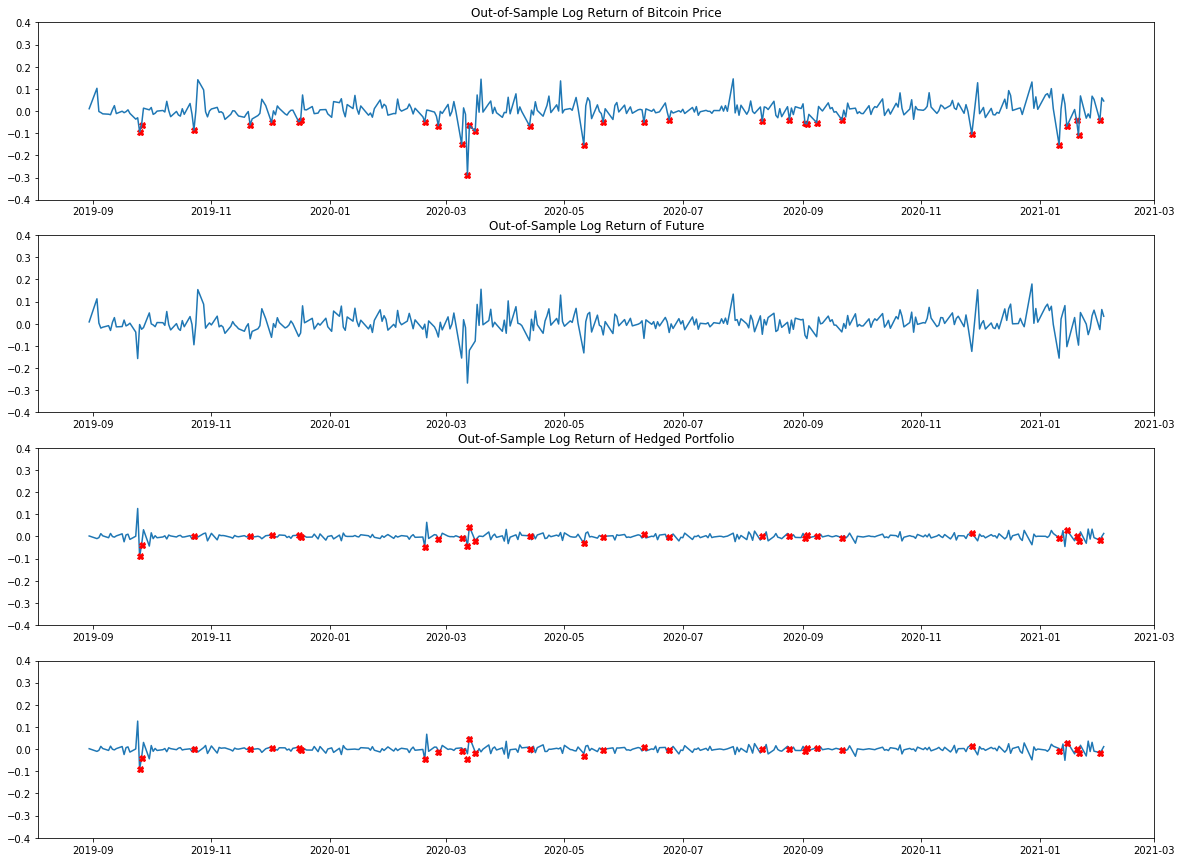

In [14]:
_id_rs = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs
_id_rf = (rf<=np.quantile(rs,30/len(rf))) # 30 smallest rs

fig, ax = plt.subplots(figsize=(20,15), nrows=4, ncols=1)
ax[0].plot(rs[_id_rs],'rX')
ax[0].plot(rs)
ax[0].set_ylim((-0.4,0.4))
ax[0].set_title("Out-of-Sample Log Return of Bitcoin Price")

# ax[1].plot(rf[_id_rf],'rX')
ax[1].plot(rf)
ax[1].set_ylim((-0.4,0.4))
ax[1].set_title("Out-of-Sample Log Return of Future")

C = 'Gumbel'
ax[2].plot(rh.loc[C,:])
ax[2].plot(rh.T.loc[_id_rs, C], 'rX')
ax[2].set_ylim((-0.4,0.4))
ax[2].set_title("Out-of-Sample Log Return of Hedged Portfolio")

ax[3].plot(rs - rf)
ax[3].set_ylim((-0.4,0.4))
ax[3].plot(rh.T.loc[_id_rs, C], 'rX')

plt.savefig('../latex/_pics/OOSreturns_compare.pdf')

In [15]:
print(1-ERM_estimate_trapezoidal(10,rh.loc['Gumbel'])/ERM_estimate_trapezoidal(10,rs), 
      1-ERM_estimate_trapezoidal(10,rs-rf)/ERM_estimate_trapezoidal(10,rs))

0.6316774032750925 0.6168773492710722


In [16]:
print(1-VaR(0.01,rh.loc['Gumbel'])/VaR(0.01,rs), 
      1-VaR(0.01,rs-rf)/VaR(0.01,rs))

0.6576502876078889 0.6478225517821796


In [17]:
print(1-VaR(0.05,rh.loc['Gumbel'])/VaR(0.05,rs), 
      1-VaR(0.05,rs-rf)/VaR(0.05,rs))

0.6148475868120744 0.5936945591437658


In [18]:
print(1-ES(0.05,rh.loc['Gumbel'])/ES(0.05,rs), 
      1-ES(0.05,rs-rf)/ES(0.05,rs))

0.6539901996936714 0.6490397201888876


In [19]:
print(1-ES(0.01,rh.loc['Gumbel'])/ES(0.01,rs), 
      1-ES(0.01,rs-rf)/ES(0.01,rs))

0.6969785918038855 0.6838254735634246


In [20]:
print(1-Variance(rh.loc['Gumbel'])/Variance(rs), 
      1-Variance(rs-rf)/Variance(rs))

0.8720514613854253 0.8636668681118549


(-0.4, 0.4)

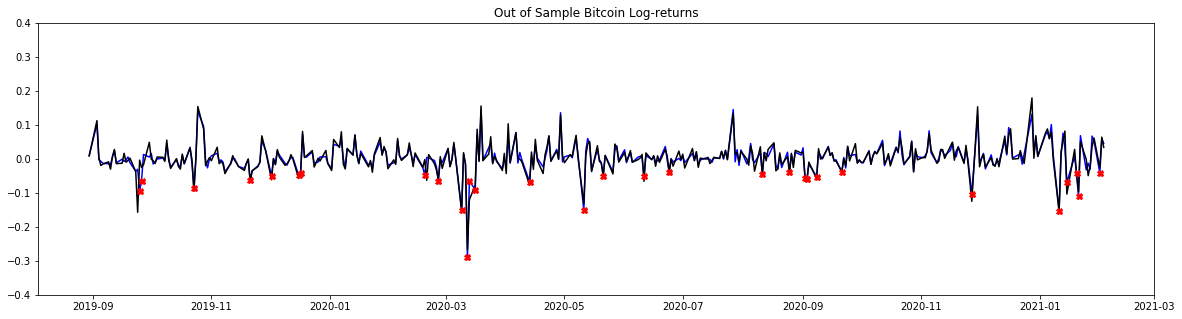

In [22]:
plt.figure(figsize=(20,5))
q=0.1
plt.title('Out of Sample Bitcoin Log-returns')
# print(np.sum(_id))
# _id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
_id = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs

plt.plot(rs, 'b')
plt.plot(rf, 'black')
# _id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
plt.plot(rs[_id],'rX')
plt.ylim((-0.4,0.4))

# plt.plot(rf[_id],'bX')
# plt.savefig('../latex/_pics/OOSBitcoin.png', transparent=True)
# _id = (rs>np.quantile(rs,1-q)) & (rf>np.quantile(rf,1-q)) 
# plt.plot(rs[_id],'rX')
# plt.plot(rf[_id],'bX')

In [23]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.1

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

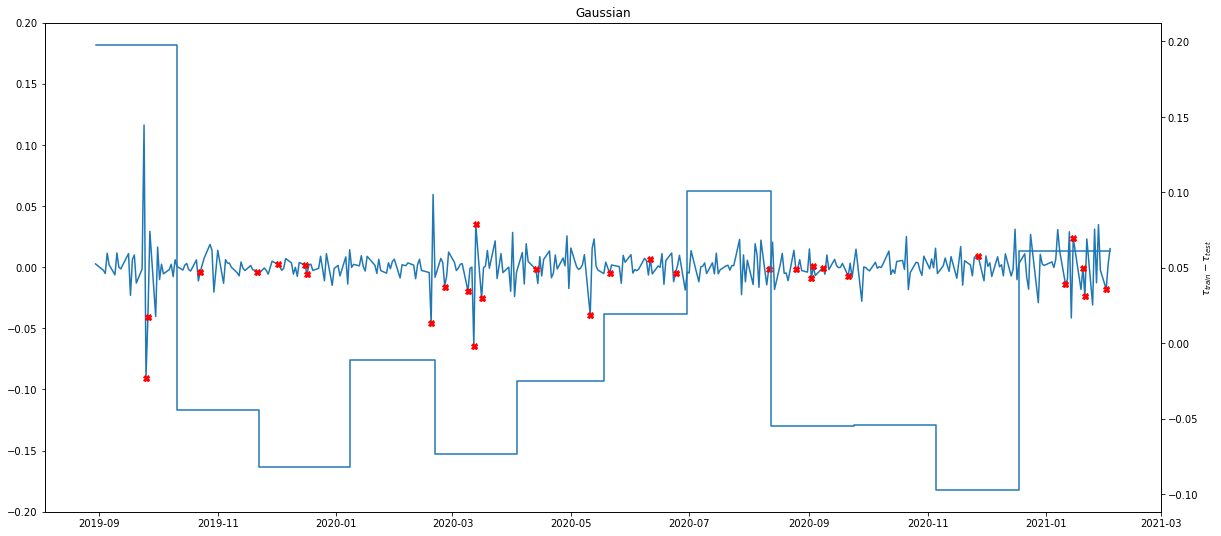

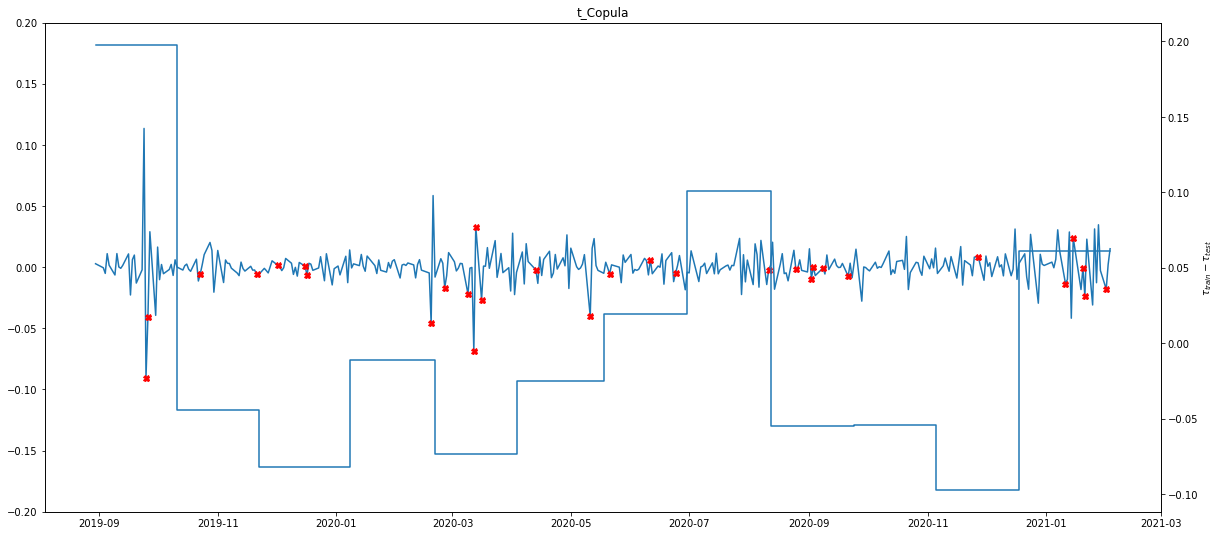

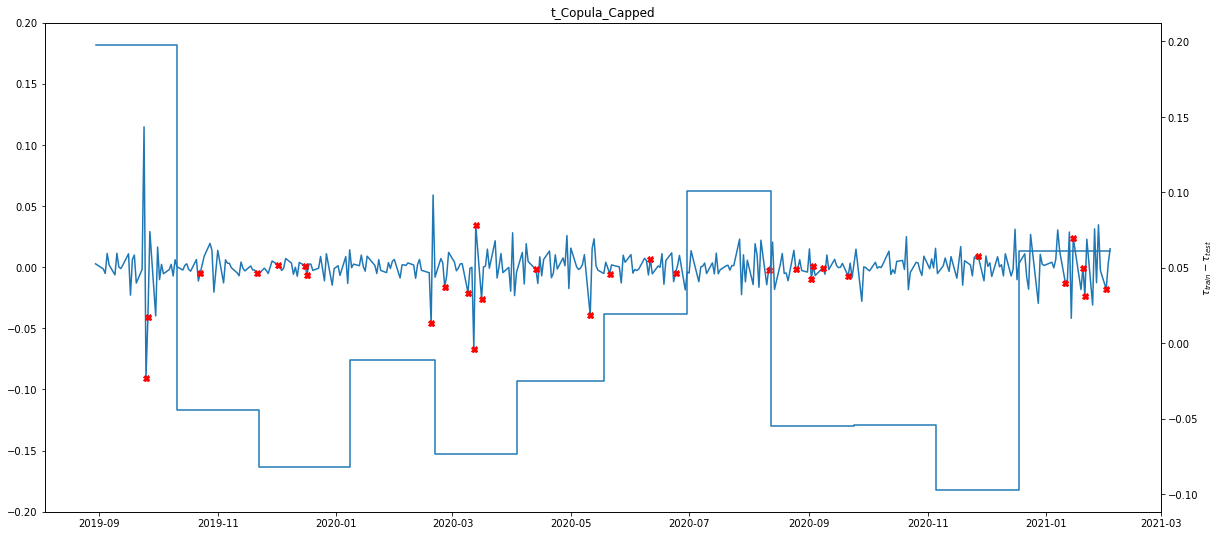

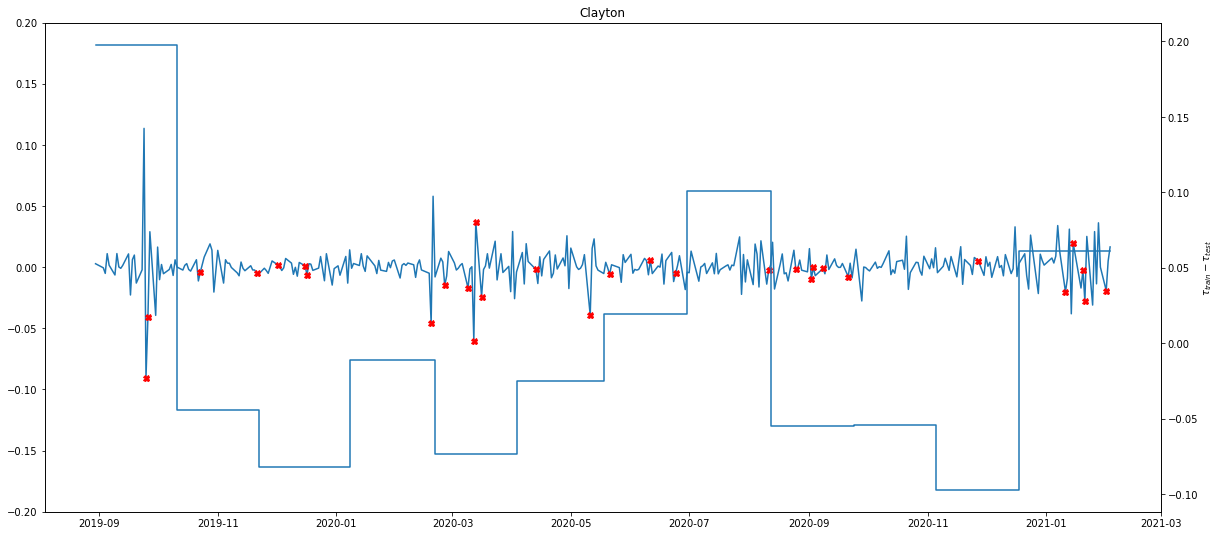

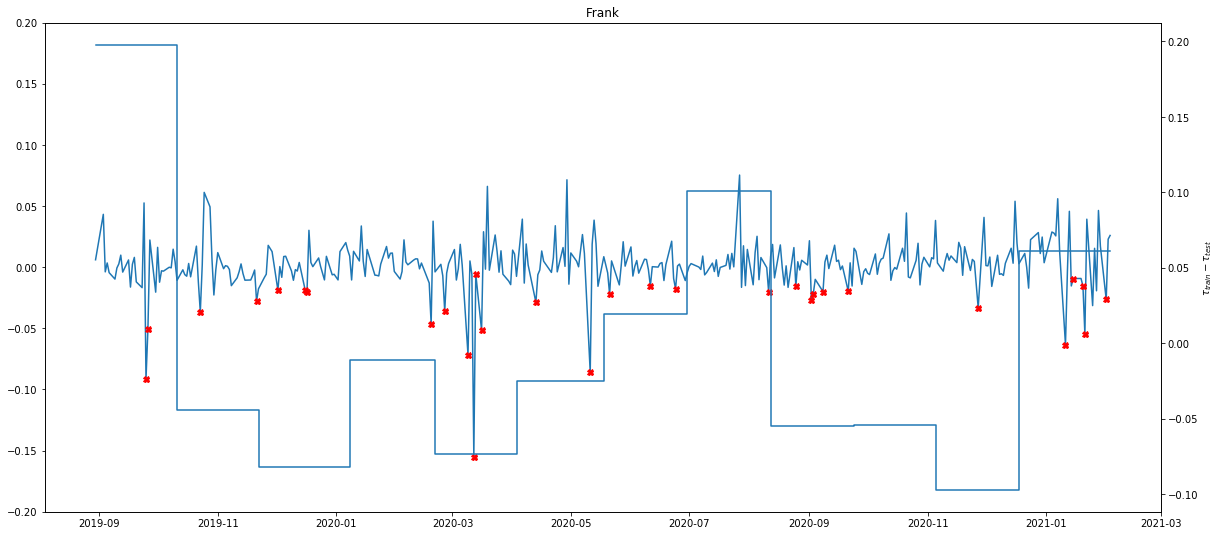

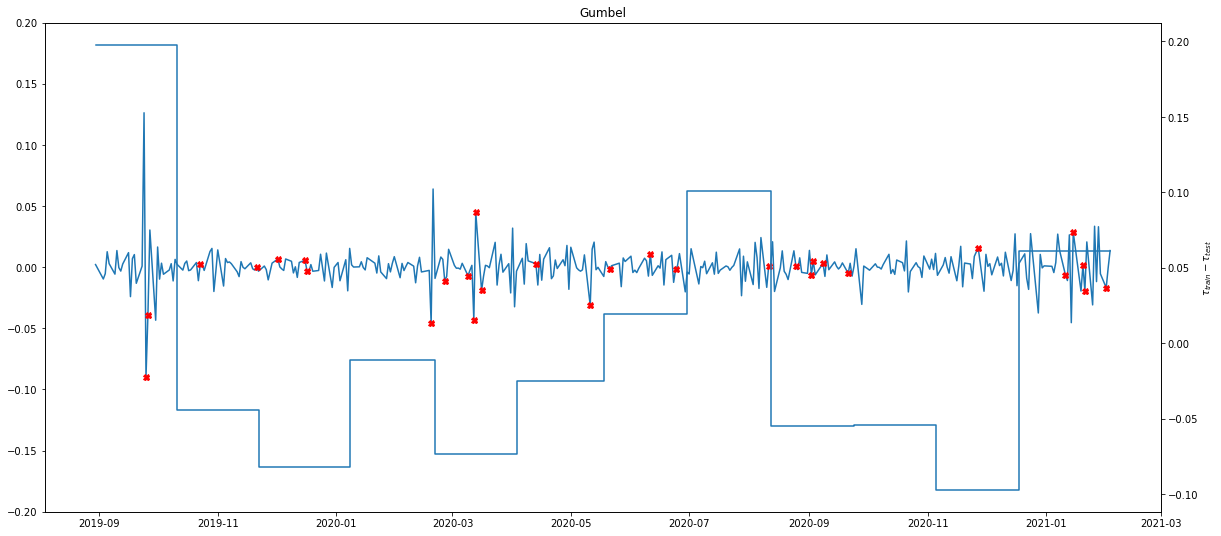

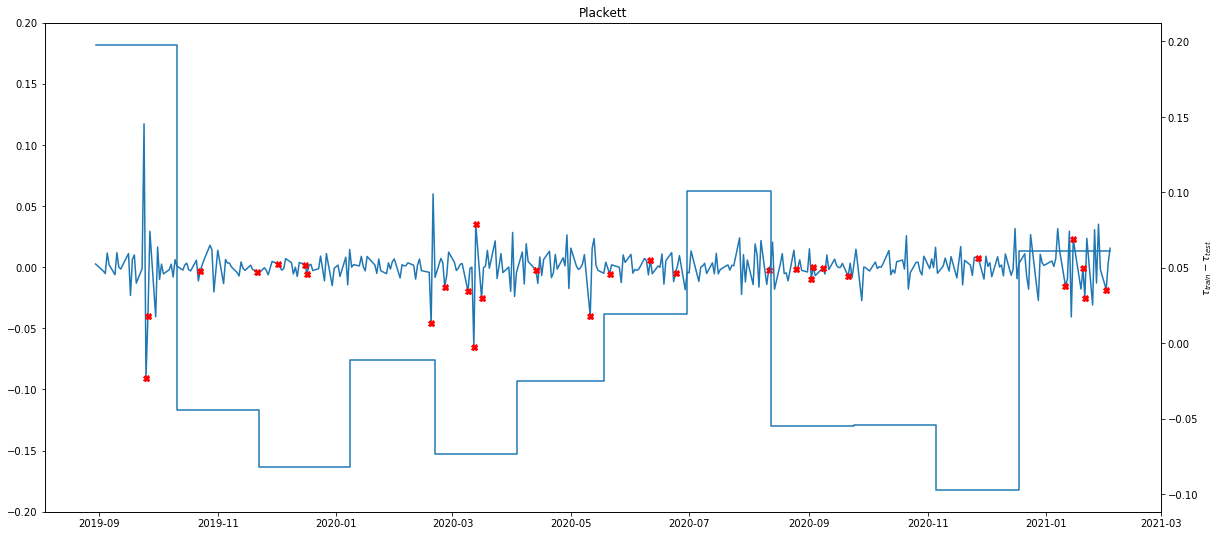

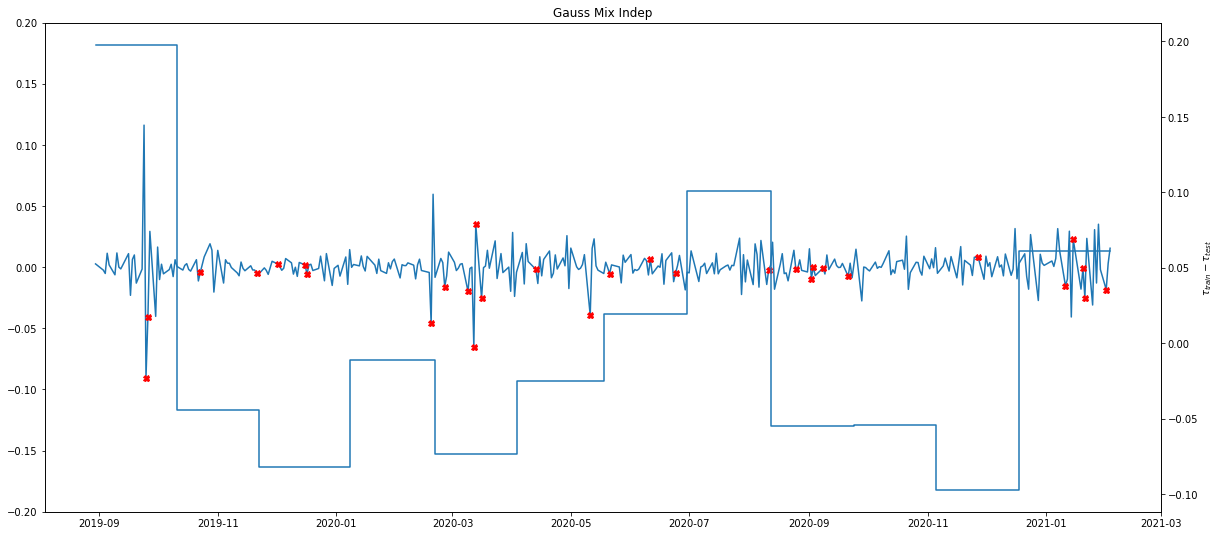

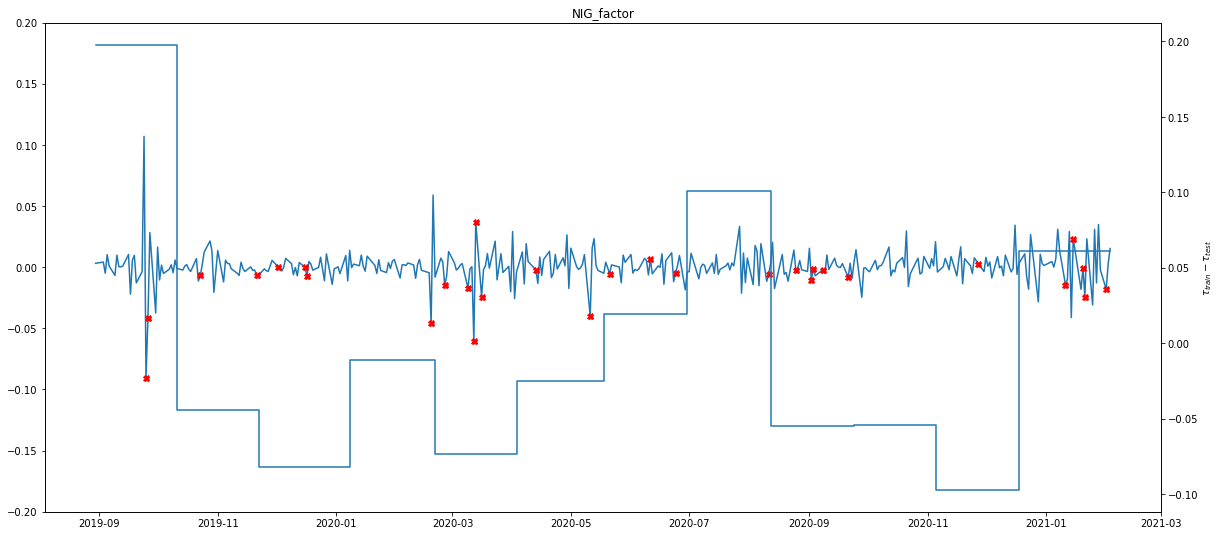

In [24]:
for i in range(len(Copula_names)):
    fig, ax1 = plt.subplots(figsize=(20,1*len(Copula_names)))
    ax2 = ax1.twinx()  
    C = Copula_names[i]
#     plt.figure(figsize=(20,5))
    ax1.set_title(Copula_names[i])
    ax1.plot(rh.loc[C,:])
    ax1.plot(rh.T.loc[_id, C], 'rX')
    ax1.set_ylim((-0.2,0.2))

    ax2.step(tau_arr.index, tau_arr)
    ax2.set_ylabel(r'$\tau_{train} - \tau_{test}$')

#     plt.plot(rh.loc[C,rs_L.index],'rx')
#     plt.plot(rh.loc[C,rs_U.index],'r+')
#     plt.plot(rh.loc[C,rf_L.index],'bx')
#     plt.plot(rh.loc[C,rf_U.index],'b+')
#     plt.ylim((-0.2,0.2))
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], q), xmin=rh.columns[0], xmax=rh.columns[-1])
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], 1-q), xmin=rh.columns[0], xmax=rh.columns[-1])

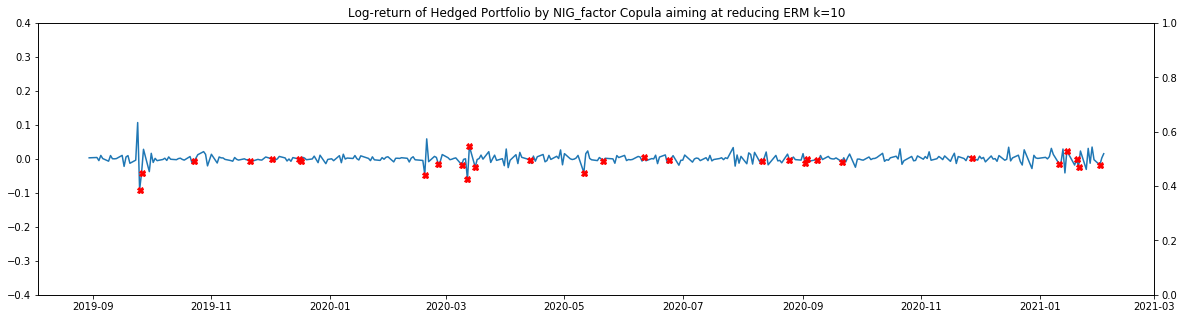

In [25]:
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()  
C = Copula_names[i]
#     plt.figure(figsize=(20,5))
ax1.set_title('Log-return of Hedged Portfolio by '+ Copula_names[i]+' Copula aiming at reducing '+rm)
ax1.plot(rh.loc[C,:])
ax1.plot(rh.T.loc[_id, C], 'rX')
ax1.set_ylim((-0.4,0.4))
plt.savefig('../latex/_pics/Gumbel_rh.png', transparent=True)
# _rh = rh.loc[C,:]
# S = pd.Series({'mean':np.mean(_rh), 
#  'std':np.std(_rh),
#  'skew':stats.skew(_rh),
#  'kurt':stats.kurtosis(_rh),
#  'max': np.max(_rh),
#  'UQ': np.quantile(_rh, 0.75),
#  'median': np.quantile(_rh, 0.5),
#  'LQ': np.quantile(_rh, 0.25), 
#  'min':np.min(_rh)})
# plt.figure(figsize=(5,5))
# sns.distplot(_rh)
# print(S)

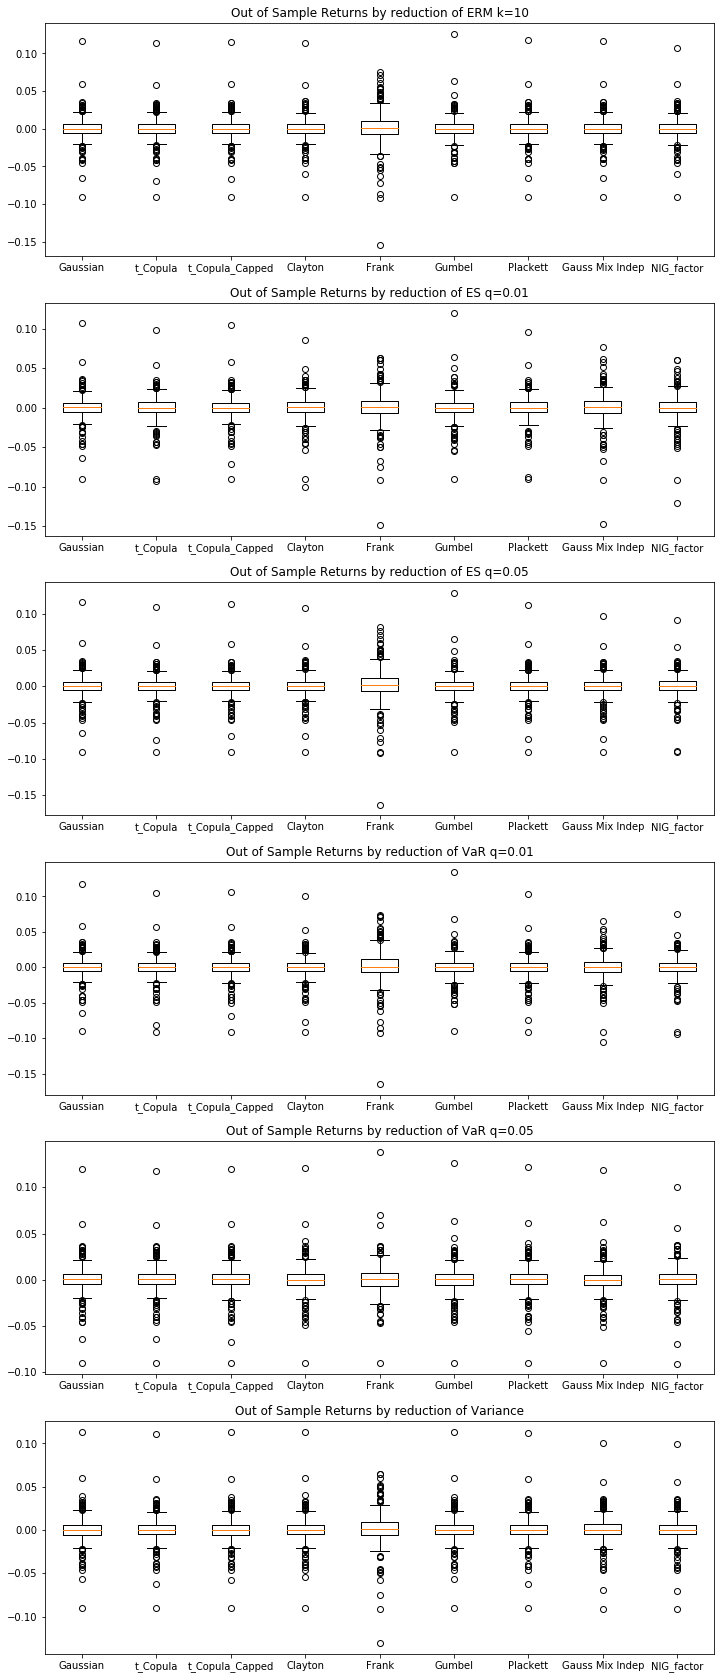

In [26]:
from plotly.subplots import make_subplots
fig, ax = plt.subplots(len(risk_measures), 1, figsize=(12,5*len(risk_measures)))
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)
    ax[i].boxplot(rh)
    ax[i].set_xticklabels(Copula_names)
    ax[i].set_title("Out of Sample Returns by reduction of %s" %rm)
    M = np.mean(rh, axis=1)
    STD = np.std(rh, axis=1)

    MAX = np.max(rh, axis=1)
    MAX_date = rh.isin(MAX).idxmax(axis=1)

    UQ = rh.apply(lambda x: np.quantile(x, 0.75, interpolation='higher'), axis=1)
    UQ_date = rh.isin(UQ).idxmax(axis=1)

    LQ = rh.apply(lambda x: np.quantile(x, 0.25, interpolation='higher'), axis=1)
    LQ_date = rh.isin(LQ).idxmax(axis=1)

    MIN = np.min(rh, axis=1)
    MIN_date = rh.isin(MIN).idxmax(axis=1)

    rh_stats = pd.concat([M, STD, MAX, MAX_date, UQ, UQ_date, LQ, LQ_date, MIN, MIN_date], axis=1)
    rh_stats.columns = ['mean', 'std', 
                        'max', 'max on',
                        'UQ', 'UQ on', 
                        'LQ', 'LQ on',
                        'min', 'min on']
    rh_stats.to_html(result_path+'rh_stats_%s.html'%rm)



    for C in Copula_names:
        _rh = rh.loc[C,:]

        fig = make_subplots(
            rows=3, cols=2,
            column_widths=[10, 10],
            row_heights=[10, 10, 10],
            specs=[[{"type":"xy","colspan": 2}, None],
                   [{"type":"xy","colspan": 2}, None],
                   [{"type": "histogram2d"}, {"type":"table"}]],
            subplot_titles=("Rh Time Series","OHR", "Histogram", "Rh Statistics"))
        
        # Line plot with extreme data points
        df = pd.DataFrame(_rh).reset_index()
        fig.add_trace(go.Scatter(x=df.loc[:,'Date'], y=df.loc[:,C]), row=1,col=1)
        fig.add_trace(go.Scatter(x=rh.T.loc[_id, C].index, y=rh.T.loc[_id, C],
                            mode='markers'))
        fig.update_yaxes(range=[-0.2, 0.2], row=1, col=1)

        
        # Step plot of h
        dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
        end_date = _rh.index[-1]
        h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
        h_4plot = h_4plot.sort_index(axis=1)
        h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
        fig.add_trace(go.Scatter(x=pd.to_datetime(h_4plot.columns), y=h_4plot.loc[C,:], line= {"shape": 'hv'}),
                      row=2,col=1)
        fig.update_yaxes(range=[np.min(np.min(OHR))*.9, np.max(np.max(OHR))*1.1], row=2, col=1)

        # Table
        S = pd.Series({'mean':np.mean(_rh), 
         'std':np.std(_rh),
         'skew':stats.skew(_rh),
         'kurt':stats.kurtosis(_rh),
         'max': np.max(_rh),
         'UQ': np.quantile(_rh, 0.75),
         'median': np.quantile(_rh, 0.5),
         'LQ': np.quantile(_rh, 0.25), 
         'min':np.min(_rh)})
        df = pd.DataFrame(S)
        df = df.reset_index()
        df.columns = ['Statistics', 'Value']
        fig.add_trace(go.Table(
            header=dict(values=list(df.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[df.iloc[:,0],df.iloc[:,1]],
                       fill_color='lavender',
                       align='left'))
        , row=3,col=2)

        uq = np.quantile(_rh, .75)
        lq = np.quantile(_rh, .25)
        bw = 1.06*min(np.std(_rh), (uq-lq)/1.34)*len(_rh)**(-1/5)

        distplfig = ff.create_distplot([np.array(_rh)],
                                       ['rh'], bin_size=bw, show_rug=False)

        fig.add_trace(go.Histogram(distplfig['data'][0],
                                   marker_color='red'
                                  ), row=3, col=1)

        fig.update_layout(height=1000, width=1200, title_text=C+' '+rm)

        fig.write_html(report_path+C+"_"+rm+".html")
        
plt.savefig(result_path+'Out of Sample Returns Boxplot.pdf', transparent=True)


In [27]:
h_diff_arr = []
for rm in risk_measures:
    h = OHR.droplevel(0,1).loc[:, rm]
    h_diff = np.sum(np.abs(h.iloc[:,:-1] - h.iloc[:,1:]), axis=1)
    h_diff_arr.append(h_diff)

In [28]:
h_diff_df = pd.concat(h_diff_arr, axis=1)
h_diff_df.columns = risk_measures

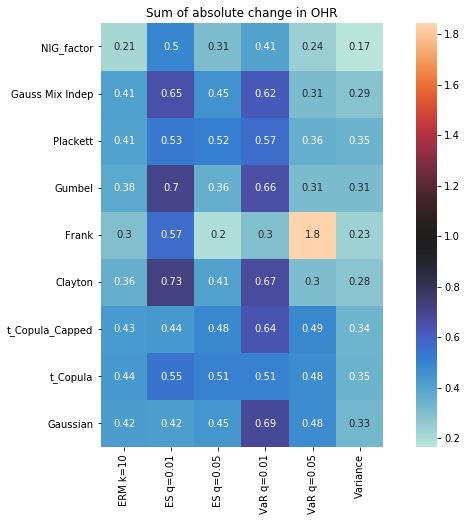

In [29]:
plt.figure(figsize=(9*1.3,6*1.3))
# sns.cubehelix_palette(as_cmap=True, reverse=True)
sns.heatmap(h_diff_df,square=True, center=True, annot=True)
plt.ylim(0,len(h_diff_df))
plt.title('Sum of absolute change in OHR')
plt.savefig(result_path+'Sum of absolute change in OHR.pdf', transparent=True)

In [30]:
h_diff_df.iloc[[0,1,2,3,5,6,7,8],:].style.highlight_min(color = 'lightgreen', axis = 0)

,ERM k=10,ES q=0.01,ES q=0.05,VaR q=0.01,VaR q=0.05,Variance
Gaussian,0.424121,0.418555,0.447266,0.688379,0.47832,0.326563
t_Copula,0.437988,0.548633,0.510449,0.508887,0.478613,0.34834
t_Copula_Capped,0.431543,0.435938,0.483984,0.641602,0.485742,0.336914
Clayton,0.35752,0.725488,0.405078,0.674023,0.303906,0.282812
Gumbel,0.378809,0.703418,0.358203,0.661035,0.314551,0.310254
Plackett,0.407617,0.528516,0.517187,0.569531,0.357422,0.346777
Gauss Mix Indep,0.412305,0.652051,0.454395,0.619922,0.309766,0.289746
NIG_factor,0.213111,0.496569,0.30921,0.406143,0.242524,0.165471


In [50]:
def hedging_effectiveness2(rm, rh, rs):
	if rm.startswith('Variance'):
		return 1 - Variance(rh) / Variance(rs)

	elif rm.startswith('ERM'):
		k = float(rm[rm.find('=') + 1:])
		return 1 - ERM_estimate_trapezoidal(k, rh) / ERM_estimate_trapezoidal(k, rs)

	elif rm.startswith('ES'):
		q = float(rm[rm.find('=') + 1:])
		return 1 - ES(q, rh) / ES(q, rs)

	elif rm.startswith('VaR'):
		q = float(rm[rm.find('=') + 1:])
		return 1 - VaR(q, rh) / VaR(q, rs)

In [51]:
for C in Copula_names:
    print(hedging_effectiveness2(rm=rm, rh=rh.loc[C,:], rs=rs))

0.8790213910739513
0.878952386385152
0.8790735581605535
0.8795195855706561
0.8018684522567674
0.8786255904081907
0.8781703878377567
0.8783335515000239
0.8795666680197877


In [53]:
HE2 = []
rm = 'ES q=0.01'
C='NIG_factor'

for _ in range(1000):
    _id = np.random.choice(range(len(rh.loc[C,:])),len(rh.loc[C,:]), True)
    HE2.append(hedging_effectiveness2(rm=rm,
                                      rh=rh.loc[C,:].iloc[_id],
                                      rs=rs.iloc[_id]))
    


In [82]:
OHR.iloc[[0,1,3,4,5,6,7,8]]

10.csv                                                      \
                 ERM k=10 ES q=0.01 ES q=0.05 VaR q=0.01 VaR q=0.05  Variance   
Gaussian         0.868359  0.821094  0.859961   0.846387   0.914844   0.86123   
t_Copula         0.850195  0.753906  0.818457   0.806543   0.894238  0.838477   
Clayton          0.863379  0.688184   0.81084   0.760937   0.939453  0.870117   
Frank            0.520117  0.527051  0.491895   0.497168     1.0709  0.588672   
Gumbel           0.933984  0.911816  0.954004    1.04463   0.947754  0.857812   
Plackett         0.876074  0.747266  0.831934   0.788281   0.926758  0.845215   
Gauss Mix Indep  0.862402  0.419238  0.739648   0.491992   0.904687  0.778418   
NIG_factor       0.836589  0.529114  0.754048   0.693326   0.826963  0.803767   

                    8.csv                                 ...     2.csv  \
                 ERM k=10 ES q=0.01 ES q=0.05 VaR q=0.01  ... ES q=0.05   
Gaussian         0.872363  0.853516  0.869531     0.8625  ...  0.915625   
t_Copula         0.858203   0.77998  0.838477   0.831836  ...  0.916113   
Clayton          0.849121  0.703418  0.811914   0.771191  ...  0.891699   
Frank            0.525977  0.522559  0.497266   0.493359  ...  0.516113   
Gumbel           0.943262  0.949121   0.96416    1.01631  ...   1.00342   
Plackett         0.879492  0.777246  0.851074   0.815332  ...  0.902344   
Gauss Mix Indep  0.875195  0.483105  0.805762   0.566504  ...  0.908496   
NIG_factor       0.864685  0.576881  0.776586   0.662963  ...  0.874074   

                                                    0.csv                      \
                VaR q=0.01 VaR q=0.05  Variance  ERM k=10 ES q=0.01 ES q=0.05   
Gaussian          0.861816   0.862305  0.916992   0.89248  0.985156  0.917969   
t_Copula          0.964746   0.881836  0.902441   0.89502  0.971289  0.933984   
Clayton           0.892285   0.890625   0.91543  0.850977  0.874805  0.837402   
Frank             0.566016   0.874121  0.663477  0.573145  0.737793  0.522461   
Gumbel             1.00488   0.913086  0.897559  0.939551   1.03984  0.980957   
Plackett          0.943066   0.870703   0.89043  0.882324  0.972461  0.913379   
Gauss Mix Indep   0.879004   0.908008  0.853809  0.882715  0.875586  0.934277   
NIG_factor        0.895922   0.859813  0.840848  0.888932  0.914826  0.906892   

                                                 
                VaR q=0.01 VaR q=0.05  Variance  
Gaussian          0.985156   0.829297  0.909473  
t_Copula          0.984766   0.831445   0.90166  
Clayton           0.978906   0.847656  0.911523  
Frank             0.588184   0.831152  0.658301  
Gumbel             1.01504   0.882031  0.906738  
Plackett          0.988281   0.859375  0.892578  
Gauss Mix Indep   0.918359   0.876562  0.859961  
NIG_factor        0.930919   0.804835   0.87334  

[8 rows x 72 columns]

In [47]:
def rename_rm(rm):
    rm = rm.replace('q=','')
    rm = rm.replace('0.01', '99%')
    rm = rm.replace('0.05', '95%')
    return rm

rename_rm('ES q=0.01')

'ES 99%'

In [225]:
OHR2 = OHR.iloc[[0,2,3,4,5,6,7,8]] # remove t copula, leaving only the capped version

ls = OHR.melt().variable_0.unique()
Copula_names = list(OHR2.index)
HE2 = np.ones((len(risk_measures),len(ls), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for j, file in enumerate(ls):
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR2.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)
        
        for k, C in enumerate(Copula_names):
            HE2[i, j, k]= hedging_effectiveness2(rm=rm, rh=rh.loc[C,:], rs=rs)

In [259]:
OHR_results = []
for i, C in enumerate(Copula_names):
    df = OHR2.iloc[i:i+1,:].melt()
    df.columns = ['file', 'risk_measure', 'OHR']
    df.loc[:,'copula'] = C
    
    OHR_results.append(df)
    
OHR_results = pd.concat(OHR_results)

In [260]:
OHR_results

,file,risk_measure,OHR,copula
0,10.csv,ERM k=10,0.868359,Gaussian
1,10.csv,ES q=0.01,0.821094,Gaussian
2,10.csv,ES q=0.05,0.859961,Gaussian
3,10.csv,VaR q=0.01,0.846387,Gaussian
4,10.csv,VaR q=0.05,0.914844,Gaussian
5,10.csv,Variance,0.86123,Gaussian
6,8.csv,ERM k=10,0.872363,Gaussian
7,8.csv,ES q=0.01,0.853516,Gaussian
8,8.csv,ES q=0.05,0.869531,Gaussian
9,8.csv,VaR q=0.01,0.8625,Gaussian


In [226]:
for i, rm in enumerate(risk_measures):
    plt.figure(figsize=(10,5))
    plt.title("Hedging Effectiveness "+ rename_rm(rm))
    plt.boxplot(HE2[i,:,:])
    plt.xticks(range(1, len(Copula_names)+1), Copula_names)
    path = '../latex/_pics/hedging_effectiveness_30days/'
    plt.savefig(path+'%s_30days.pdf'%rename_rm(rm).replace(' ', '_'))
    plt.close()


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histogram

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histogram

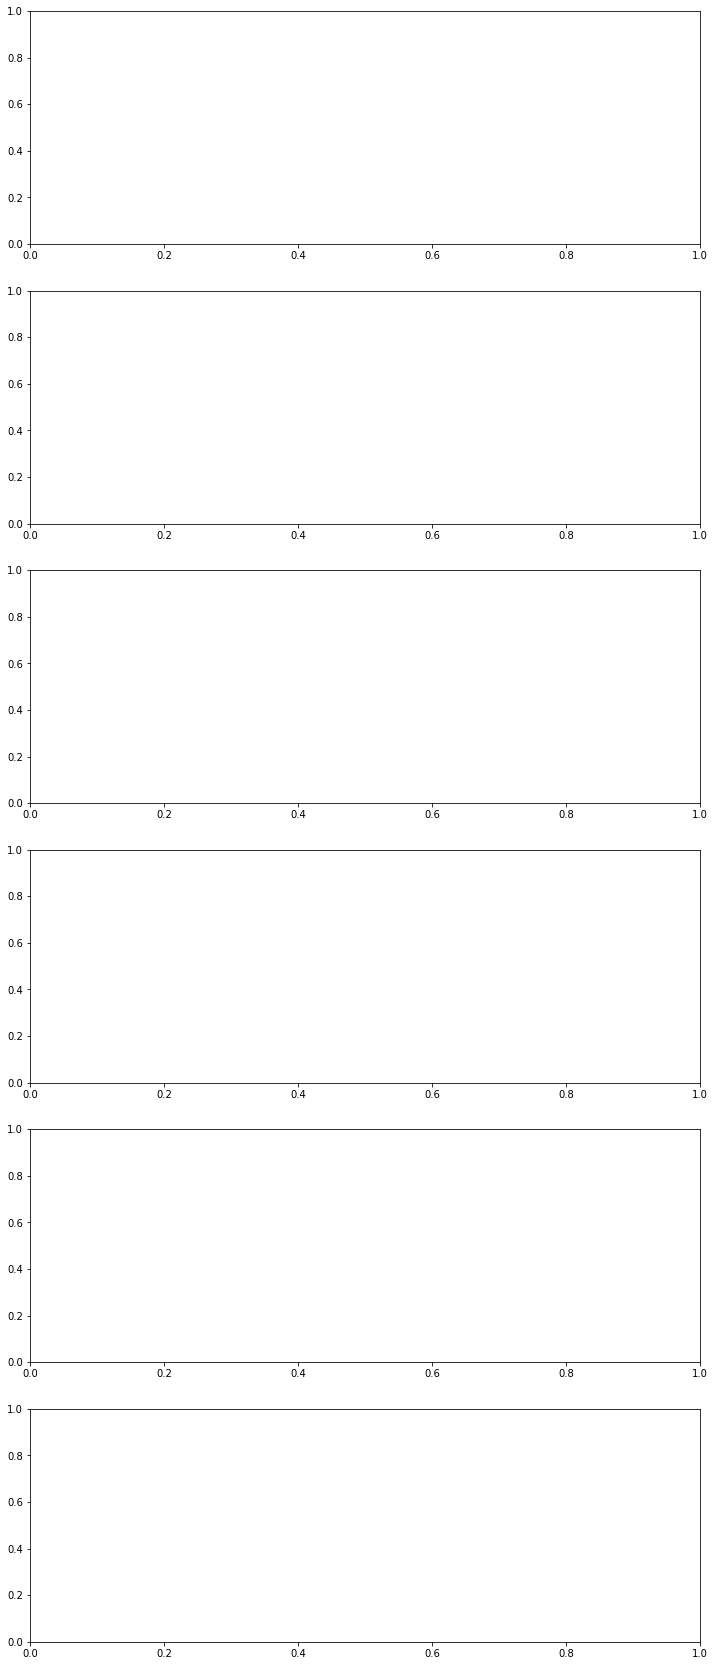

In [163]:
# _id = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs
fig, ax = plt.subplots(len(risk_measures), 1, figsize=(12,5*len(risk_measures)))

for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR2.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)
    for C in Copula_names:
        plt.figure(figsize=(10,5))
        sns.distplot(rh.iloc[6,:])
        plt.xlabel('Log Return')
        plt.xlim((-0.15,0.15))
        plt.title('Out-of-Sample Hedged Portfolio Returns Using ' + C + ' minimizing '+ rename_rm(rm))
        path = '../latex/_pics/OOS_returns_30days/'
        plt.savefig(path+'OOS_returns_%s_%s_30days.pdf'%(C, rename_rm(rm).replace(' ', '_')))
        plt.close()#     plt.plot()

In [266]:
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR2.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)

In [269]:
rh.iloc[i:i+1, :].melt()

,Date,value
0,2019-08-30,0.002906
1,2019-09-03,0.000741
2,2019-09-04,-0.005052
3,2019-09-05,0.010837
4,2019-09-06,0.001443
5,2019-09-09,-0.006470
6,2019-09-10,0.010790
7,2019-09-11,0.000264
8,2019-09-12,-0.000629
9,2019-09-13,0.001268


In [272]:
rs

Date
2019-08-30    0.010440
2019-09-03    0.102632
2019-09-04   -0.002124
2019-09-05   -0.006875
2019-09-06   -0.012721
2019-09-09   -0.014291
2019-09-10   -0.016676
2019-09-11    0.006093
2019-09-12    0.024493
2019-09-13   -0.011426
2019-09-16   -0.000823
2019-09-17   -0.007489
2019-09-18   -0.002733
2019-09-19    0.005404
2019-09-20   -0.010730
2019-09-23   -0.036552
2019-09-24   -0.030371
2019-09-25   -0.093663
2019-09-26   -0.063650
2019-09-27    0.012980
2019-09-30    0.005381
2019-10-01    0.015894
2019-10-02   -0.015115
2019-10-03   -0.009952
2019-10-04   -0.000366
2019-10-07    0.002502
2019-10-08   -0.004359
2019-10-09    0.043880
2019-10-10    0.002356
2019-10-11   -0.025490
                ...   
2020-12-21    0.011727
2020-12-22    0.013921
2020-12-23   -0.015543
2020-12-24    0.014825
2020-12-28    0.131110
2020-12-29    0.012303
2020-12-30    0.064054
2020-12-31    0.007677
2021-01-04    0.072591
2021-01-05    0.078559
2021-01-06    0.059696
2021-01-07    0.101218
2021-0

In [162]:
plt.figure(figsize=(10,5))
sns.distplot(rf)
plt.xlabel('Log Return')
plt.xlim((-0.30,0.15))
plt.title('Out-of-Sample Bitcoin Future')

plt.savefig('OOS_BTC_future.pdf')
plt.close()#     plt.plot()

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



In [161]:
plt.figure(figsize=(10,5))
sns.distplot(rs)
plt.xlabel('Log Return')
plt.xlim((-0.30,0.15))
plt.title('Out-of-Sample BTC returns')

plt.savefig('OOS_BTC_return.pdf')
plt.close()#     plt.plot()

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



In [224]:
for C in Copula_names:
    for rm in risk_measures:
        _temp = []
        for file in ls:
            testing_file = pd.read_csv('../processed_data/'+data_name+'/test/'+file)
            testing_file.Date = pd.to_datetime(testing_file.Date)
            testing_file.loc[:,"h"] = OHR2.loc[C, file][rm]
            _temp.append(testing_file)
            
        h_to_plot = pd.concat(_temp)
        h_to_plot.sort_values("Date", inplace=True)
        
        plt.figure(figsize=(10,5))
        plt.title('Calibrated OHR by %s minimizing %s' %(C, rename_rm(rm)))
        plt.ylim((0.4,1.2))
        plt.plot(h_to_plot.Date, h_to_plot.h)
        path = '../latex/_pics/OHR_30days/'
        plt.savefig(path+'OHR_%s_%s_30days.pdf'%(C, rename_rm(rm).replace(' ', '_')))
        plt.close() 

In [212]:
h_to_plot = pd.concat(_temp)
h_to_plot.sort_values("Date", inplace=True)
plt.plot(h_to_plot.Date, h_to_plot.h)

In [222]:
plt.figure(figsize=(10,5))
plt.title('Calibrated OHR by %s minimizing %s' %(C, rename_rm(rm)))
plt.ylim((0.6,1.2))
plt.plot(h_to_plot.Date, h_to_plot.h)
path = '../latex/_pics/OHR_30days/'
plt.savefig(path+'OHR_%s_%s_30days.pdf'%(C, rename_rm(rm).replace(' ', '_')))
plt.close()#     plt.plot()

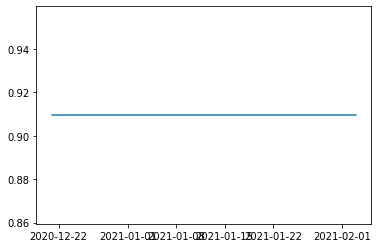

In [204]:
plt.plot(testing_file.Date, testing_file.h)

NameError: name 'rh_df' is not defined

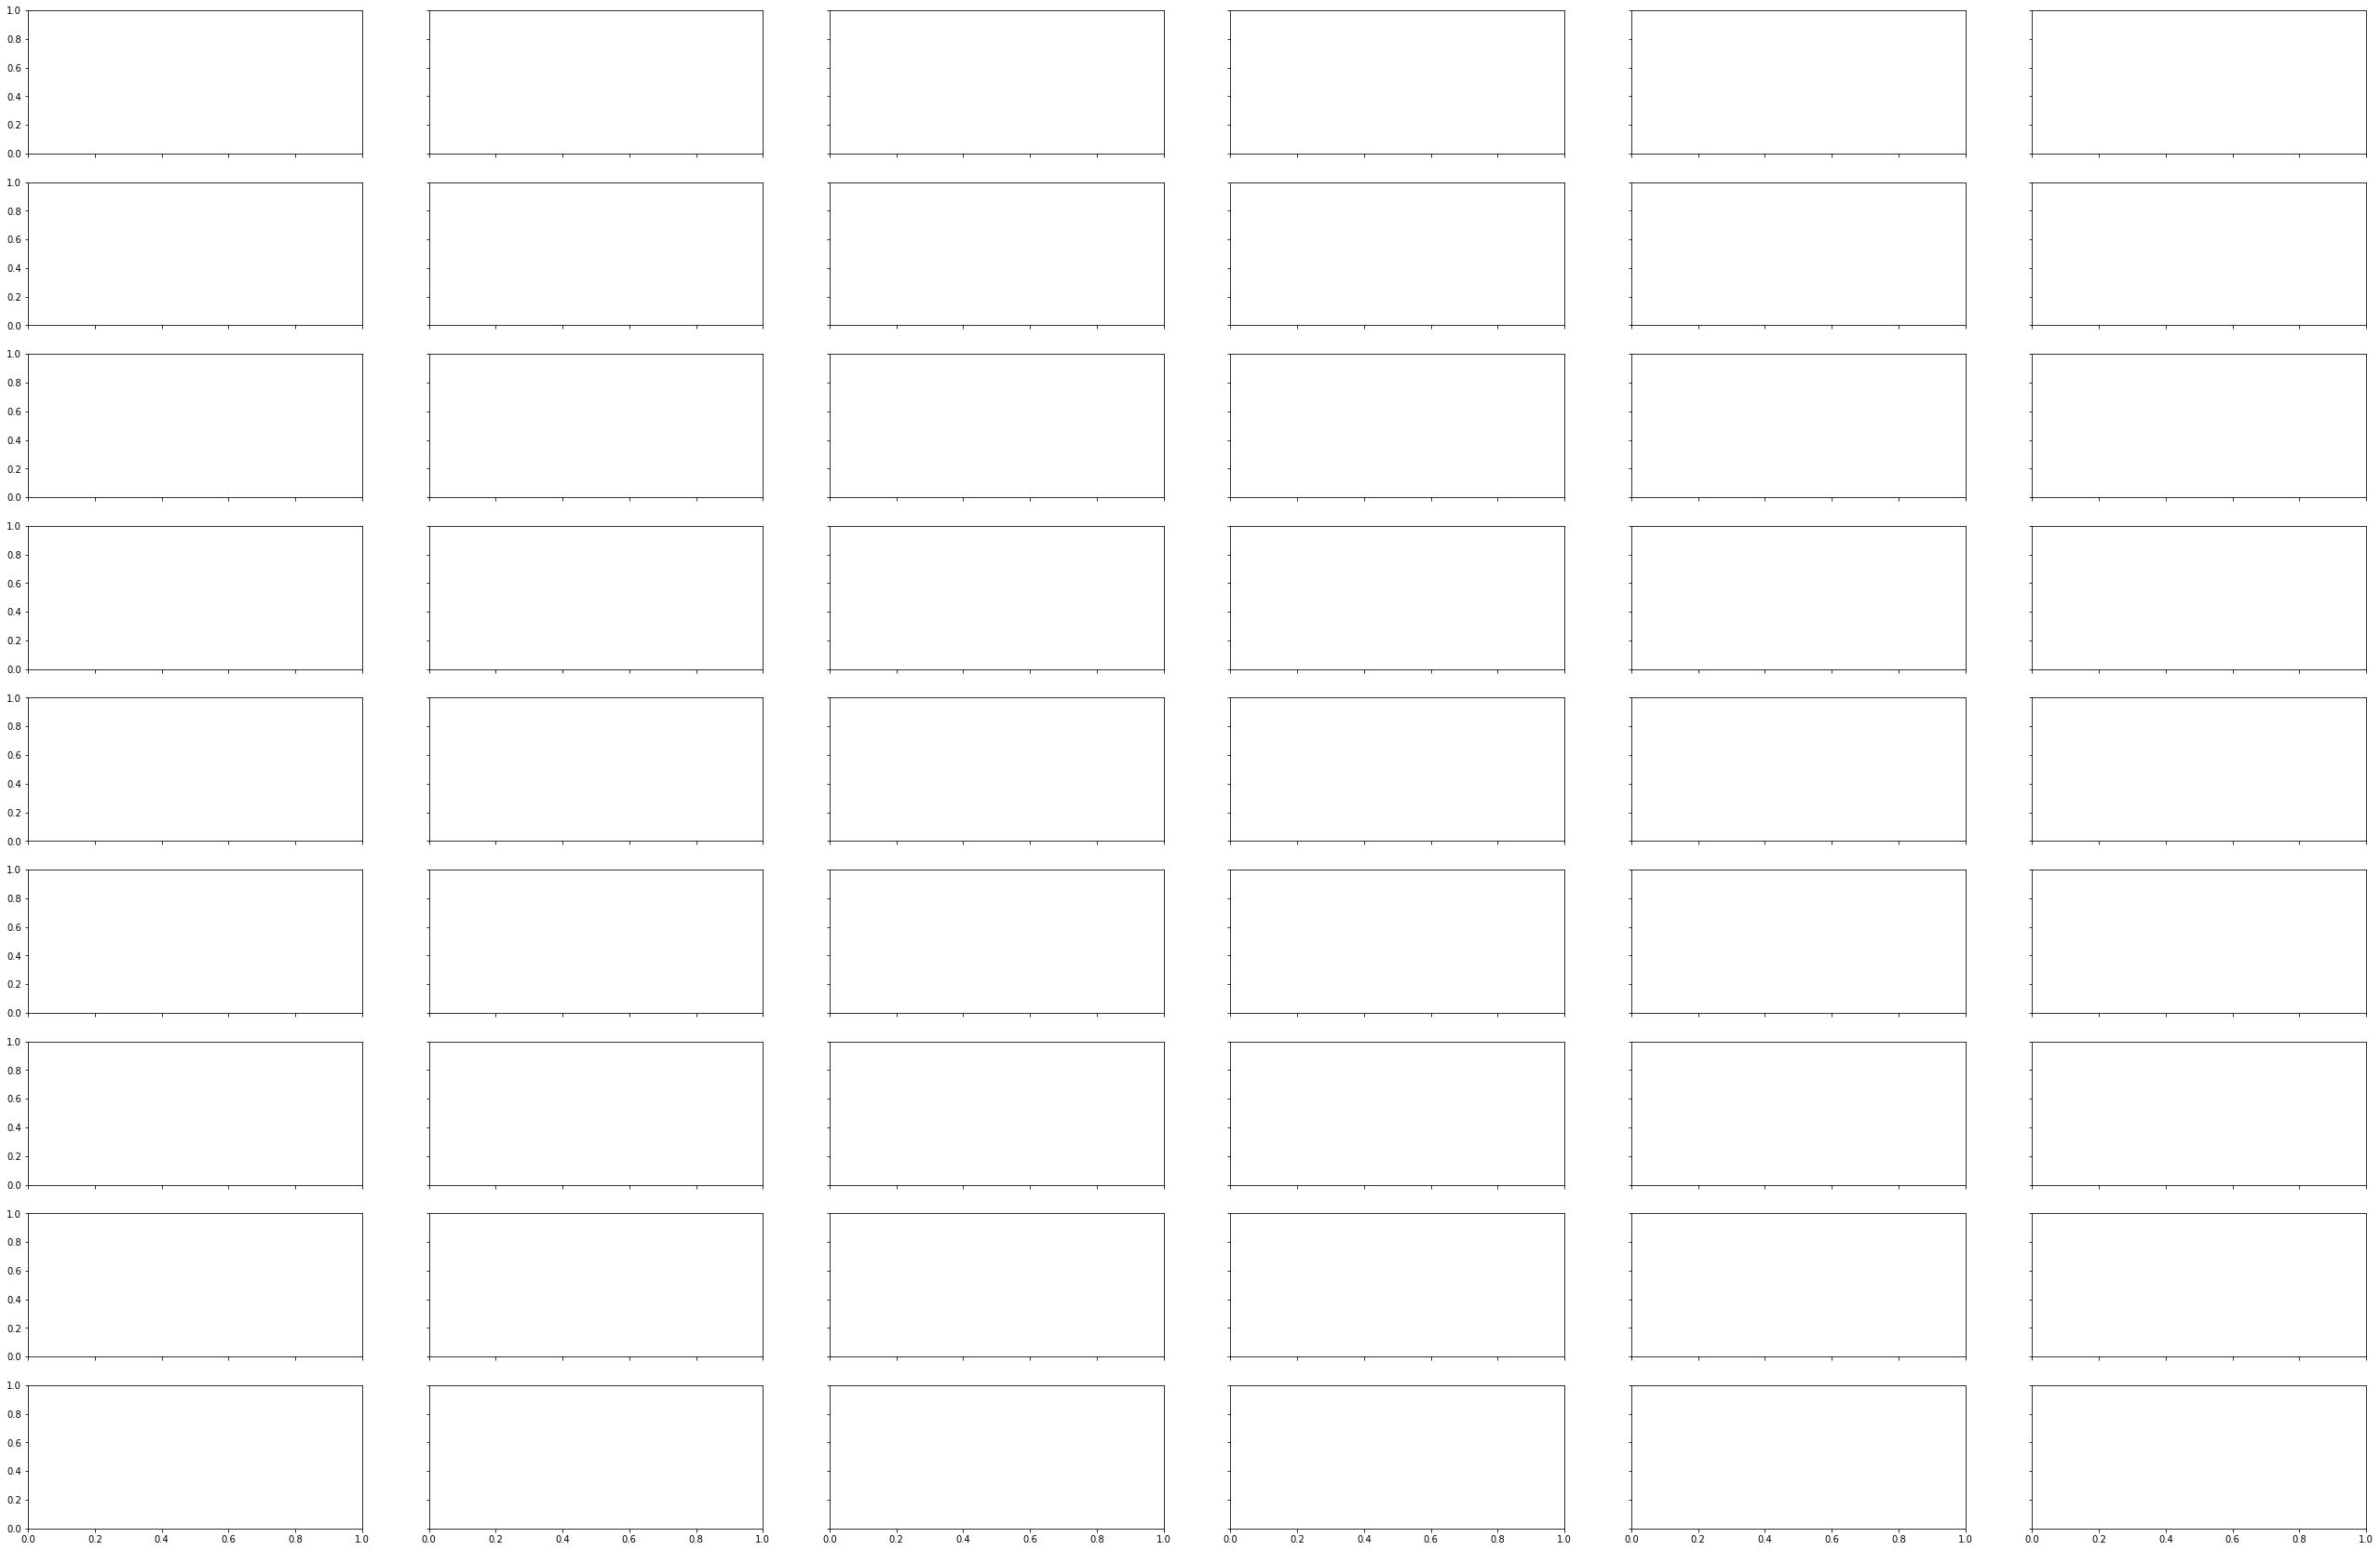

In [46]:
# N=2
fig, ax = plt.subplots(len(Copula_names),
                       len(risk_measures), 
                       figsize=(5*len(Copula_names),5*len(risk_measures)),
                       sharey=True,  sharex=True)

for i in range(len(Copula_names)):
    for j in range(len(risk_measures)):
        ax[i, j].plot(rh_df[j].T.loc[:,Copula_names[i]])
        ax[i,j].set_ylim((-0.15,0.15))
        if j==0:
            ax[i,j].set_ylabel(Copula_names[i])
        if i==0:
            ax[i,j].set_title(rename_rm(risk_measures[j]))
        ax[i,j].scatter(x= _id[_id].index, y=rh_df[j].T.loc[_id,Copula_names[i]], color='r')
plt.tight_layout(pad=0.01)
plt.savefig('../latex/_pics/Rhs.pdf', transparent=True)

In [ ]:

HE_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        HE_np[i,j]=hedging_effectiveness2(rm, rh_df[i].loc[C,:], rs)

In [ ]:
HE_overall = pd.DataFrame(HE_np).T
HE_overall.columns = [rename_rm(rm) for rm in risk_measures]
HE_overall.index = Copula_names
HE_overall.style.highlight_max(color = 'lightgreen', axis = 0)

In [ ]:
Variance_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        Variance_np[i,j]=Variance(rh_df[i].loc[C,:])**0.5
        
Variance_overall = pd.DataFrame(Variance_np).T
Variance_overall.columns = [rename_rm(rm) for rm in risk_measures]
Variance_overall.index = Copula_names
Variance_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
Variance_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
ERM_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ERM_np[i,j]=ERM_estimate_trapezoidal(10, rh_df[i].loc[C,:])
        
ERM_overall = pd.DataFrame(ERM_np).T
ERM_overall.columns = [rename_rm(rm) for rm in risk_measures]
ERM_overall.index = Copula_names
ERM_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
ERM_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
VaR_99_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        VaR_99_np[i,j]=VaR(.01, rh_df[i].loc[C,:])
        
VaR_99_overall = pd.DataFrame(VaR_99_np).T
VaR_99_overall.columns = [rename_rm(rm) for rm in risk_measures]
VaR_99_overall.index = Copula_names
VaR_99_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
VaR_99_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
VaR_95_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        VaR_95_np[i,j]=VaR(.05, rh_df[i].loc[C,:])
        
VaR_95_overall = pd.DataFrame(VaR_95_np).T
VaR_95_overall.columns = [rename_rm(rm) for rm in risk_measures]
VaR_95_overall.index = Copula_names
VaR_95_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [ ]:
VaR_95_overall.style.highlight_min(color = 'lightgreen', axis = 0)

In [ ]:
ES_99_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ES_99_np[i,j]=ES(.01, rh_df[i].loc[C,:])
        
ES_99_overall = pd.DataFrame(ES_99_np).T
ES_99_overall.columns = [rename_rm(rm) for rm in risk_measures]
ES_99_overall.index = Copula_names
ES_99_overall.style.highlight_min(color = 'lightgreen', axis = 1)

In [37]:
ES_99_overall.style.highlight_min(color = 'lightgreen', axis = 0)

NameError: name 'ES_99_overall' is not defined

In [111]:
ES_95_np = np.ones((len(risk_measures), len(Copula_names)))
for i, rm in enumerate(risk_measures):
    for j, C in enumerate(Copula_names):
        ES_95_np[i,j]=ES(.05, rh_df[i].loc[C,:])
        
ES_95_overall = pd.DataFrame(ES_95_np).T
ES_95_overall.columns = [rename_rm(rm) for rm in risk_measures]
ES_95_overall.index = Copula_names
ES_95_overall.style.highlight_min(color = 'lightgreen', axis = 1)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0347774,0.035638,0.0348519,0.0359094,0.0349944,0.0342865
t_Copula,0.0350866,0.0379191,0.0356037,0.036435,0.0346707,0.0345252
t_Copula_Capped,0.0349005,0.0360371,0.0351585,0.0355429,0.0347392,0.0343704
Clayton,0.0339855,0.0381297,0.0345452,0.0355141,0.0334452,0.0340916
Frank,0.0525252,0.047122,0.0555002,0.0533276,0.034765,0.0459337
Gumbel,0.0340553,0.0364684,0.0346499,0.0361854,0.0337115,0.0342506
Plackett,0.0347486,0.0374588,0.03557,0.0362724,0.0341403,0.0344715
Gauss Mix Indep,0.0347216,0.0456495,0.0354895,0.0398294,0.0338411,0.034777
NIG_factor,0.0343159,0.0419507,0.0371707,0.0377039,0.0350889,0.034999


In [112]:
ES_95_overall.style.highlight_min(color = 'lightgreen', axis = 0)

,ERM k=10,ES 99%,ES 95%,VaR 99%,VaR 95%,Variance
Gaussian,0.0347774,0.035638,0.0348519,0.0359094,0.0349944,0.0342865
t_Copula,0.0350866,0.0379191,0.0356037,0.036435,0.0346707,0.0345252
t_Copula_Capped,0.0349005,0.0360371,0.0351585,0.0355429,0.0347392,0.0343704
Clayton,0.0339855,0.0381297,0.0345452,0.0355141,0.0334452,0.0340916
Frank,0.0525252,0.047122,0.0555002,0.0533276,0.034765,0.0459337
Gumbel,0.0340553,0.0364684,0.0346499,0.0361854,0.0337115,0.0342506
Plackett,0.0347486,0.0374588,0.03557,0.0362724,0.0341403,0.0344715
Gauss Mix Indep,0.0347216,0.0456495,0.0354895,0.0398294,0.0338411,0.034777
NIG_factor,0.0343159,0.0419507,0.0371707,0.0377039,0.0350889,0.034999


In [113]:
# print("\\begin{table}")
# print(ERM_overall.to_latex(index=True))
# print("\\caption{Exponential Risk Measure $k=10$}")
# print("\\end{table}")

# print("\\begin{table}")
# print(ES_99_overall.to_latex(index=True))
# print("\\caption{ES 99\%}")
# print("\\end{table}")

# print("\\begin{table}")
# print(ES_95_overall.to_latex(index=True))
# print("\\caption{ES 95\%}")
# print("\\end{table}")

print("\\begin{table}")
print(VaR_99_overall.to_latex(index=True))
print("\\caption{VaR 99\%}")
print("\\end{table}")

# print("\\begin{table}")
# print(VaR_95_overall.to_latex(index=True))
# print("\\caption{VaR 95\%}")
# print("\\end{table}")

# print("\\begin{table}")
# print(Variance_overall.to_latex(index=True))
# print("\\caption{Variance}")
# print("\\end{table}")


\begin{table}
\begin{tabular}{lrrrrrr}
\toprule
{} &  ERM k=10 &    ES 99\% &    ES 95\% &   VaR 99\% &   VaR 95\% &  Variance \\
\midrule
Gaussian        &  0.041453 &  0.045906 &  0.042359 &  0.046327 &  0.041644 &  0.042227 \\
t\_Copula        &  0.041877 &  0.044826 &  0.043668 &  0.046009 &  0.041553 &  0.042282 \\
t\_Copula\_Capped &  0.041701 &  0.045309 &  0.043019 &  0.046239 &  0.041416 &  0.042255 \\
Clayton         &  0.039866 &  0.046187 &  0.041015 &  0.045725 &  0.040455 &  0.042305 \\
Frank           &  0.068284 &  0.056641 &  0.074298 &  0.068848 &  0.040503 &  0.054027 \\
Gumbel          &  0.042739 &  0.043390 &  0.042397 &  0.045773 &  0.041262 &  0.042102 \\
Plackett        &  0.040971 &  0.045065 &  0.042511 &  0.045826 &  0.040423 &  0.041847 \\
Gauss Mix Indep &  0.041138 &  0.049952 &  0.044375 &  0.045059 &  0.040761 &  0.043000 \\
NIG\_factor      &  0.041510 &  0.047636 &  0.043426 &  0.045355 &  0.042359 &  0.043242 \\
\bottomrule
\end{tabular}

\caption{Va

In [39]:
h_4plot_arr = []
_rh = rh.loc[C,:]

for rm in risk_measures:
    dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
    end_date = _rh.index[-1]
    h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
    h_4plot = h_4plot.sort_index(axis=1)
    h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
    h_4plot.columns = pd.to_datetime(h_4plot.columns)
    h_4plot_arr.append(h_4plot)

In [40]:
risk_measures

Index(['ERM k=10', 'ES q=0.01', 'ES q=0.05', 'VaR q=0.01', 'VaR q=0.05',
       'Variance'],
      dtype='object')

In [48]:
# fig, ax = plt.subplots(len(Copula_names),
#                        len(risk_measures), 
#                        figsize=(5*len(Copula_names),5*len(risk_measures)),
#                        sharey=True,  sharex=True)

# for i in range(len(Copula_names)):
#     for j in range(len(risk_measures)):
#         ax[i, j].plot(rh_df[j].T.loc[:,Copula_names[i]])
#         ax[i,j].set_ylim((-0.15,0.15))
#         if j==0:
#             ax[i,j].set_ylabel(Copula_names[i])
#         if i==0:
#             ax[i,j].set_title(rename_rm(risk_measures[j]))
#         ax[i,j].scatter(x= _id[_id].index, y=rh_df[j].T.loc[_id,Copula_names[i]], color='r')
# plt.tight_layout(pad=0.01)
# plt.savefig('../latex/_pics/Rhs.png', transparent=True)

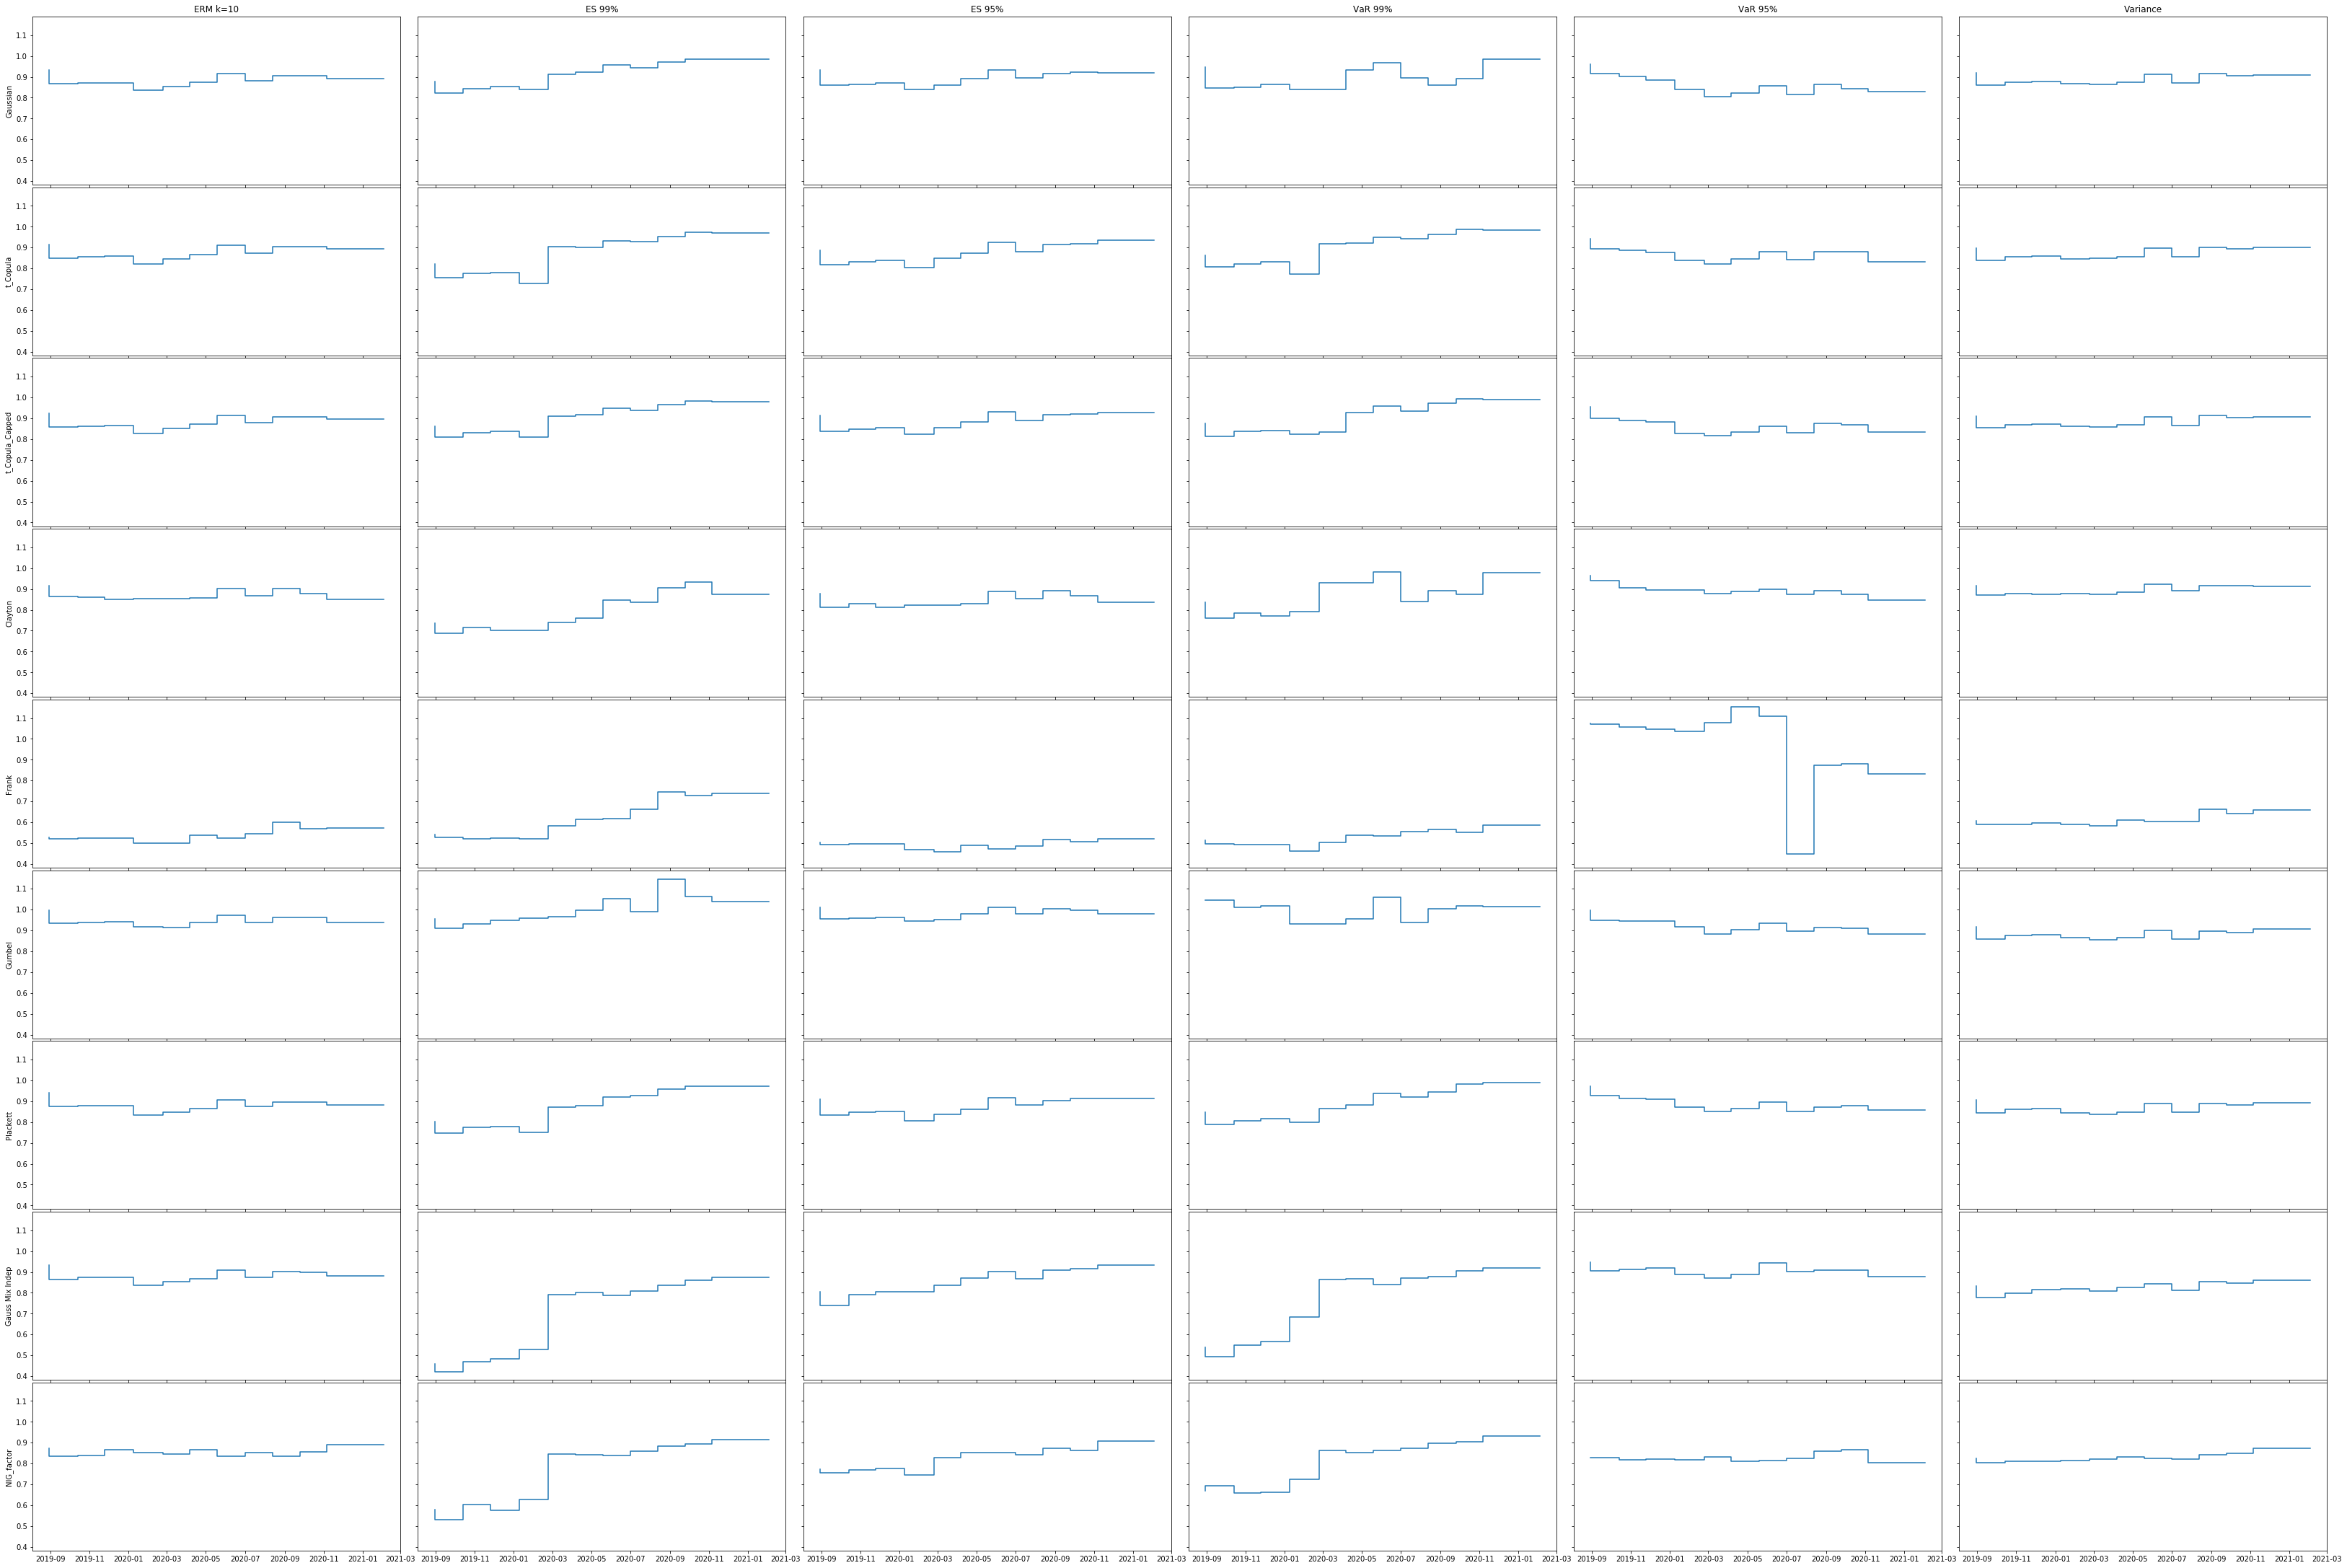

In [49]:
fig, ax = plt.subplots(len(Copula_names),
                       len(risk_measures), 
                       figsize=(5*len(Copula_names),5*len(risk_measures)),
                       sharey=True,  sharex=True)


for i, C in enumerate(Copula_names):
    for j, rm in enumerate(risk_measures):
        ax[i,j].step(x=h_4plot_arr[j].loc[C,:].index, y=h_4plot_arr[j].loc[C,:], label=risk_measures[j])
        if j==0:
            ax[i,j].set_ylabel(Copula_names[i])
        if i==0:
            ax[i,j].set_title(rename_rm(risk_measures[j]))
plt.tight_layout(pad=0.01)
plt.savefig('../latex/_pics/OHRs.pdf', transparent=True)

The overall strategy:
1. observe copula across risk reduction objective
- Kick out Frank because of HEs and PnL
- Other copula are producing similar results of HEs and PnL under the same risk reduction objective
-- PnL, conditional PnL (conditioned on extremes of RS)
- Gumbel Copula ex-ante hedge extreme by keeping a high h*
- None of the copula can escape from dependence break 

2. observe risk reduction objectives across copula
- 99% VaR and ES are too sensitive 
- ERM is a smoothed version ES --> give consistent results

1. h is high to begin with, Gumbel is consistently high, pick some of the extreme better then the others
2. consistently high h 

normal time, no extreme, h<<1
if there is extreme, correltation is higher, if one concerns extremes, maintain high h before extremes
connection to Gumbel
- combination of risk reduction objective and copula produce sensitive h*s. 
- Gumbel is better on extremes,because there is a high h ex-ante. high capture the 
- 
